# The Impact of Mental Health on Suicide Rates Across Countries

### Authors: Nick Ng, Kevin Tat, Keaton Staggs

In [7]:
%%capture
!pip install geopandas
!pip install seaborn
!pip install plotly


In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import io
from pprint import pprint

In [2]:
%%capture
suicide_data = pd.read_csv("combined_processed_data.csv")
gdp_data = pd.read_csv("gdp_1960_2020.csv")
WHO_data = pd.read_csv("GHED_data.csv", encoding='latin1')
mental_health_data = pd.read_csv("mental_disorder_data_cleaned.csv")


assert len(suicide_data) == 9538
assert len(gdp_data) == 10134
assert len(WHO_data) == 4243
assert len(mental_health_data) == 5488


assert list(suicide_data.columns) == ['Region Name', 'Country Name', 'Year', 'Sex', '0 Year', '1-4 Years',
 '5-9 Years', '10-14 Years', '15-19 Years', '20-24 Years', '25-29 Years', '30-34 Years', '35-39 Years',
 '40-44 Years', '45-49 Years', '50-54 Years', '55-59 Years', '60-64 Years', '65-69 Years',
 '70-74 Years', '75-79 Years', '80-84 Years', '85+ Years', 'Unknown Age', 'No of Suicides',
 'Percentage of cause-specific deaths out of total deaths', 'Death rate per 100 000 population']

assert list(gdp_data.columns) == ['year', 'rank', 'country', 'state', 'gdp', 'gdp_percent']

assert list(mental_health_data.columns) == ['Unnamed: 0', 'country', 'code', 'year', 'schizophrenia',
 'bipolar_disorder', 'eating_disorders', 'anxiety_disorders', 'drug_use_disorders', 'depression',
 'alcohol_use_disorders']

assert len(WHO_data.columns) == 3927

## Data Cleaning

In [3]:
def clean_country_name(s):
    """
    Takes in a country name and changes to United States if containing 
    United States and does not include Island.

    >>> clean_country_name("United States")
    'United States'
    >>> clean_country_name("the United States")
    'United States'
    >>> clean_country_name("United States Island")
    'United States Island'
    """
     
    if "United States" in s and "Island" not in s:
        return "United States"
    return s

In [4]:
import doctest
doctest.testmod()

TestResults(failed=0, attempted=3)

In [5]:
all_df = [suicide_data, gdp_data, WHO_data, mental_health_data]
col_name = ["Country Name", "country", "country", "country"]
countries = ["Japan", "United States", "Germany", "Egypt", "Brazil", "Australia", "Spain", "Italy", "Mexico", "Denmark"]
for i in range(len(all_df)):
    all_df[i][col_name[i]] = all_df[i][col_name[i]].apply(clean_country_name)
    all_df[i] = all_df[i].loc[all_df[i][col_name[i]].isin(countries)]

suicide_data_filtered = all_df[0]
gdp_data_filtered = all_df[1]
WHO_data_filtered = all_df[2]
mental_health_data_filtered = all_df[3]

In [6]:
gdp_suicide = suicide_data_filtered.merge(gdp_data_filtered, left_on=["Country Name", "Year"], right_on=["country", "year"], how="left")
WHO_suicide = suicide_data_filtered.merge(WHO_data_filtered, left_on = ["Country Name", "Year"], right_on = ["country", "year"], how = "left")
mental_suicide = suicide_data_filtered.merge(mental_health_data_filtered, left_on = ["Country Name", "Year"], right_on = ["country", "year"], how = "left")

assert len(gdp_suicide) == 1217

assert len(WHO_suicide) == 1217

assert len(mental_suicide) == 1217


## Basic Overview

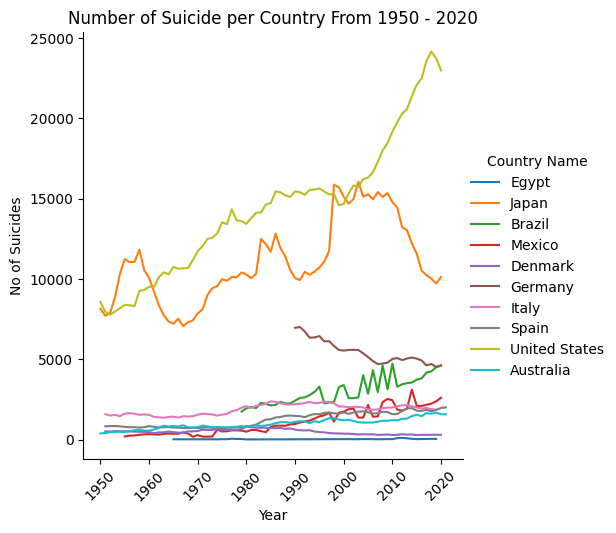

In [7]:

def line_plot_suicide_per_country(suicide_data_filtered):
    """
    Takes in a filtered dataset and returns plot of number of suicides 
    by year for each country.
    """
    p = sns.relplot(data=suicide_data_filtered, x="Year", y="No of Suicides", hue="Country Name", kind="line", errorbar = None)
    plt.xticks(rotation=45)
    plt.title("Number of Suicide per Country From 1950 - 2020")
    return p

ax = line_plot_suicide_per_country(suicide_data_filtered).facet_axis(0,0)  
assert ax.get_title() == "Number of Suicide per Country From 1950 - 2020"
assert ax.get_xlabel() == "Year", "Label does not match expected"
assert ax.get_ylabel() == "No of Suicides", "Label does not match expected"

assert sorted([tuple(xy) for xy in line.get_xydata()] for line in ax.get_lines())[10][:20] == [(1950.0, 380.0), (1951.0, 402.5), 
(1952.0, 459.5), (1953.0, 479.5), (1954.0, 484.5), (1955.0, 473.0), (1956.0, 510.5), (1957.0, 585.0), (1958.0, 603.5), 
(1959.0, 557.5), (1960.0, 546.0), (1961.0, 624.5), (1962.0, 734.5), (1963.0, 859.0), (1964.0, 810.0), (1965.0, 842.5), 
(1966.0, 812.0), (1967.0, 889.0), (1968.0, 763.5), (1969.0, 751.0)], "data not matching"



## How does the GDP of the country contribute to suicide rates?

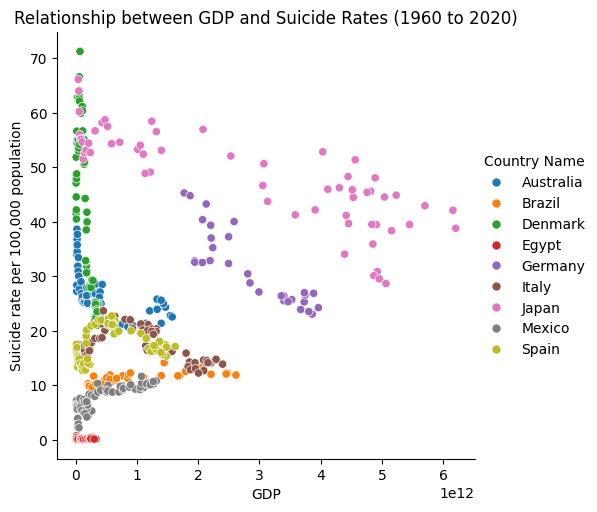

In [10]:

def gdp_suicide_rates(gdp_suicide):
    """
    Takes in filtered merged dataset and returns a plot of GDP by suicide rate for each country.
    """
    gdp_suicide_grouped = gdp_suicide.groupby(["Country Name", "Year"])["Death rate per 100 000 population"].sum().reset_index()
    gdp_suicide_merged = gdp_suicide_grouped.merge(gdp_data_filtered, left_on=["Country Name", "Year"], right_on=["country", "year"], how="left")

    not_us = gdp_suicide_merged[gdp_suicide_merged["Country Name"] != "United States"].dropna()
    p = sns.relplot(data=not_us, x="gdp", y= "Death rate per 100 000 population", hue="Country Name")
    plt.xlabel("GDP")
    plt.ylabel("Suicide rate per 100,000 population")
    plt.title(f"Relationship between GDP and Suicide Rates ({not_us['Year'].min()} to {not_us['Year'].max()})")
    return p
    
ax = gdp_suicide_rates(gdp_suicide).facet_axis(0,0)  

scatter_data = ax.collections[0].get_offsets()

sorted_data = sorted([tuple(point) for point in scatter_data])

assert sorted_data[:20] == [(4948667540.0, 0.20824984235294108), (6248946880.0, 47.39102776052631), 
    (6933842098.0, 41.50241041578947), (7812968114.0, 48.30500986789474), (8316692385.0, 47.10061221684211), 
    (9228963224.0, 0.11818802999999989), (9506678762.0, 51.84500861736842), (10098534613.0, 0.2369107894117646), 
    (10678897387.0, 44.55035200473684), (11632178868.0, 0.2398407211764705), (11931739858.0, 42.15817621473684), 
    (12072126075.0, 17.46932667), (13040000000.0, 6.861054493157894), (13059064374.0, 40.49105149105263), 
    (13315988083.0, 0.2666057858823529), (13505573866.0, 47.95767231578948), (13834300571.0, 16.533909608421055), 
    (14160000000.0, 6.975172395789474), (14400806875.0, 0.7432933294117646), (14811704063.0, 0.4581249894117647)]

assert ax.get_title() == "Relationship between GDP and Suicide Rates (1960 to 2020)"
assert ax.get_xlabel() == "GDP", "Label does not match expected"
assert ax.get_ylabel() == "Suicide rate per 100,000 population", "Label does not match expected"


In [8]:
fig = go.Figure()
gdp_suicide_grouped = gdp_suicide.groupby(["Country Name", "Year"])["Death rate per 100 000 population"].sum().reset_index()
gdp_suicide_merged = gdp_suicide_grouped.merge(gdp_data_filtered, left_on=["Country Name", "Year"], right_on=["country", "year"], how="left")

not_us = gdp_suicide_merged[gdp_suicide_merged["Country Name"] != "United States"].dropna()
for country, data in not_us.groupby('Country Name'):
    fig.add_trace(go.Scatter(x=data['gdp'], y=data['Death rate per 100 000 population'], mode='markers', name=country))

fig.update_layout(title=f"Relationship between GDP and Suicide Rates ({not_us['Year'].min()} to {not_us['Year'].max()})",
                  xaxis=dict(title="GDP"),
                  yaxis=dict(title="Suicide rate per 100,000 population"))

fig.show()

assert fig.layout.title.text == "Relationship between GDP and Suicide Rates (1960 to 2020)"
assert fig.layout.xaxis.title.text == "GDP"
assert fig.layout.yaxis.title.text == "Suicide rate per 100,000 population"



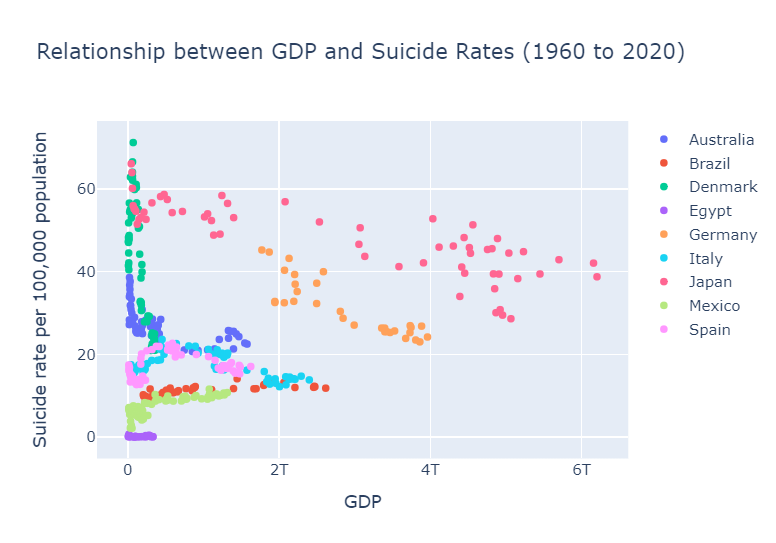

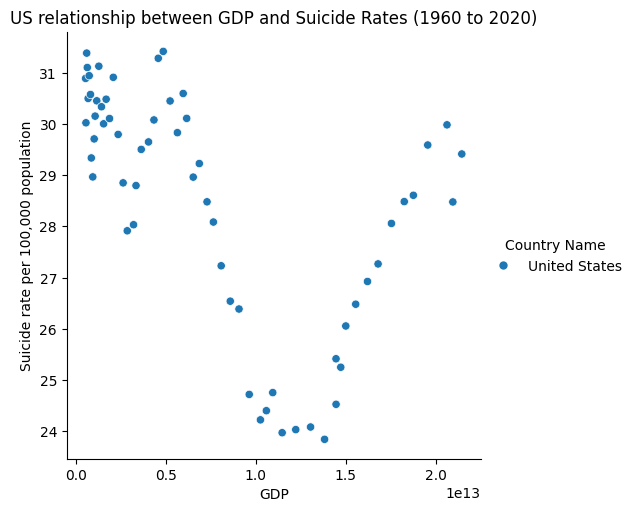

In [10]:
def us_gdp_suicide(gdp_suicide_merged):
    """
    Takes in filtered merged dataset and returns a plot of GDP by suicide rate for US only.
    """
    us = gdp_suicide_merged[gdp_suicide_merged["Country Name"] == "United States"].dropna()
    p = sns.relplot(data=us, x="gdp", y= "Death rate per 100 000 population", hue="Country Name")
    plt.xlabel("GDP")
    plt.ylabel("Suicide rate per 100,000 population")
    plt.title(f"US relationship between GDP and Suicide Rates ({not_us['Year'].min()} to {not_us['Year'].max()})")
    return p 

ax = us_gdp_suicide(gdp_suicide_merged).facet_axis(0,0)  

scatter_data = ax.collections[0].get_offsets()

sorted_data = sorted([tuple(point) for point in scatter_data])

assert sorted_data[:20] == [(543300000000.0, 30.889524441052632), (563300000000.0, 30.023582032105264), 
    (605100000000.0, 31.383513457368423), (638600000000.0, 31.10195639526316), (685800000000.0, 30.498412503157894), 
    (743700000000.0, 30.94291113631579), (815000000000.0, 30.57594122368421), (861700000000.0, 29.337372360526317), 
    (942500000000.0, 28.96740100526316), (1019900000000.0, 29.708972693684213), (1073303000000.0, 30.15368193421053), 
    (1164850000000.0, 30.45209471473684), (1279110000000.0, 31.127593080526317), (1425376000000.0, 30.33653304736842), 
    (1545243000000.0, 30.00354624368421), (1684904000000.0, 30.483564315789476), (1873412000000.0, 30.10639549105263), 
    (2081826000000.0, 30.91074395473684), (2351599000000.0, 29.796210862105262), (2627334000000.0, 28.851357429473687)]
assert ax.get_title() == "US relationship between GDP and Suicide Rates (1960 to 2020)"
assert ax.get_xlabel() == "GDP", "Label does not match expected"
assert ax.get_ylabel() == "Suicide rate per 100,000 population", "Label does not match expected"





In [9]:
us = gdp_suicide_merged[gdp_suicide_merged["Country Name"] == "United States"].dropna()

fig = go.Figure()
for country, data in us.groupby('Country Name'):
    fig.add_trace(go.Scatter(x=data['gdp'], y=data['Death rate per 100 000 population'], mode='markers', name=country))

fig.update_layout(title=f"US Relationship between GDP and Suicide Rates ({us['Year'].min()} to {us['Year'].max()})",
                  xaxis=dict(title="GDP"),
                  yaxis=dict(title="Suicide rate per 100,000 population"))

fig.show()

assert fig.layout.title.text == "US Relationship between GDP and Suicide Rates (1960 to 2020)"
assert fig.layout.xaxis.title.text == "GDP"
assert fig.layout.yaxis.title.text == "Suicide rate per 100,000 population"

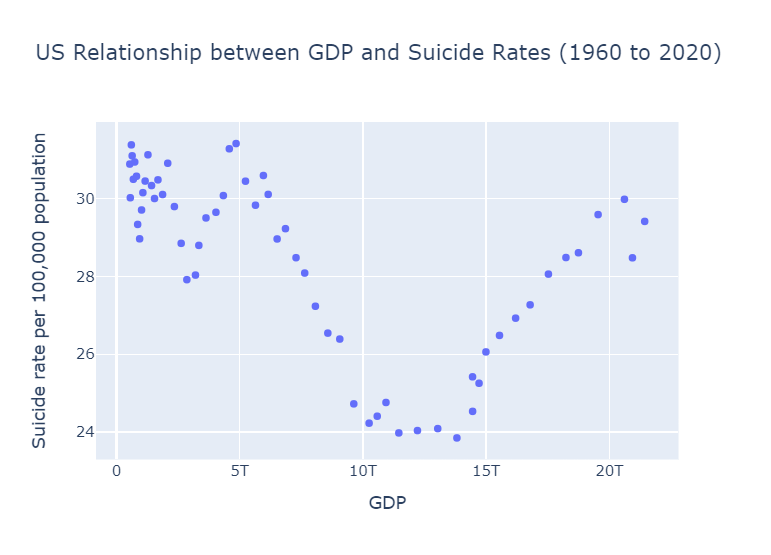

## How do trends in mental health disorders correlate with suicide rates? 


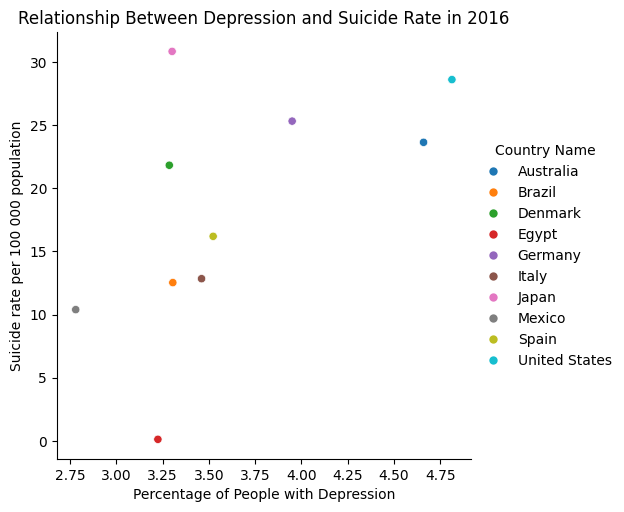

In [17]:
def mental_health_suicide(gdp_suicide_merged):
    """
    Takes in a filtered merged dataset and returns a scatterplot of the relationship
    between depression and suicide rate.
    """
    mental_suicide_grouped = mental_suicide.groupby(["Country Name", "Year"])["Death rate per 100 000 population"].sum().reset_index()
    mental_suicide_merged = mental_suicide_grouped.merge(mental_health_data_filtered, left_on=["Country Name", "Year"], right_on=["country", "year"], how="left")
    filter_year = mental_suicide_merged[mental_suicide_merged["Year"] == 2016]
    p = sns.relplot(filter_year, x="depression", y= "Death rate per 100 000 population", hue="Country Name")
    plt.xlabel("Percentage of People with Depression")
    plt.ylabel("Suicide rate per 100 000 population")
    plt.title("Relationship Between Depression and Suicide Rate in 2016")
    return p 

ax = mental_health_suicide(gdp_suicide_merged).facet_axis(0,0)  

scatter_data = ax.collections[0].get_offsets()

sorted_data = sorted([tuple(point) for point in scatter_data])
assert sorted_data[:20] == [(2.779875, 10.388423506315789), (3.224017, 0.11485214473684201), 
    (3.285642, 21.82493655368421), (3.300907, 30.841860320000002), (3.304643, 12.528912972631579), 
    (3.459977, 12.838977493157895), (3.522661, 16.194056017894738), (3.949598, 25.319549484210526), 
    (4.659817, 23.63957901052632), (4.813114, 28.608866985789476)]
assert ax.get_title() == "Relationship Between Depression and Suicide Rate in 2016"
assert ax.get_xlabel() == "Percentage of People with Depression", "Label does not match expected"
assert ax.get_ylabel() == "Suicide rate per 100 000 population", "Label does not match expected"





In [13]:
mental_suicide_grouped = mental_suicide.groupby(["Country Name", "Year"])["Death rate per 100 000 population"].sum().reset_index()
mental_suicide_merged = mental_suicide_grouped.merge(mental_health_data_filtered, left_on=["Country Name", "Year"], right_on=["country", "year"], how="left")
filter_year = mental_suicide_merged[mental_suicide_merged["Year"] == 2016]

fig = px.scatter(filter_year, x="depression", y="Death rate per 100 000 population",
                  text="Country Name",labels ={"depression":"Percentage of People with Depression",
                                                "Death rate per 100 000 population":"Suicide rate per 100 000 population" },
                                                title="Relationship Between Depression and Suicide Rate in 2016")

fig.update_traces(textposition= "top center")
fig.show()

assert fig.layout.title.text == "Relationship Between Depression and Suicide Rate in 2016"
assert fig.layout.xaxis.title.text == "Percentage of People with Depression"
assert fig.layout.yaxis.title.text == "Suicide rate per 100 000 population"

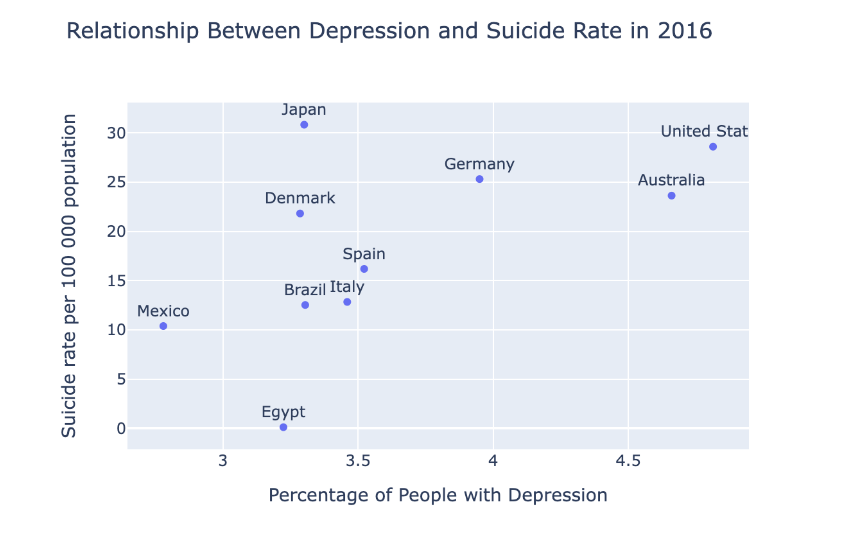

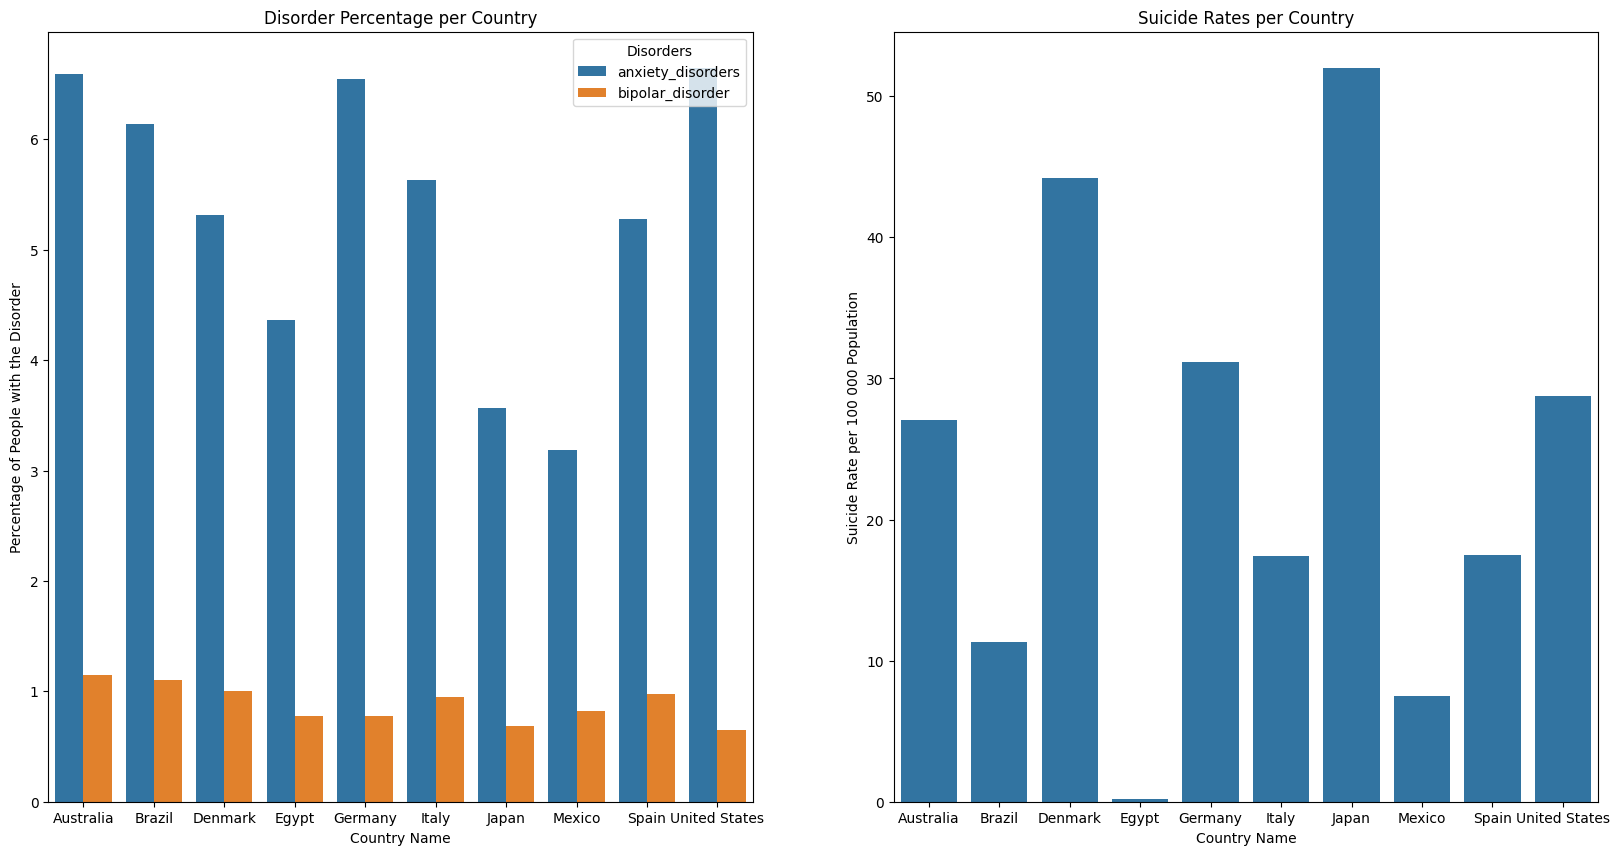

In [14]:

from seaborn.categorical import Rectangle


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
filter_year = mental_suicide_merged[mental_suicide_merged["Year"] == 2016]
melted = filter_year.melt(id_vars=["Country Name"], value_vars=["anxiety_disorders", "bipolar_disorder"], var_name="Disorders")

sns.barplot(melted, x="Country Name", y = "value", hue = "Disorders", ax=ax1)
sns.barplot(mental_suicide_merged, x = "Country Name", y = "Death rate per 100 000 population", errorbar = None, ax = ax2)
ax1.set_title("Disorder Percentage per Country")
ax1.set_ylabel("Percentage of People with the Disorder")
ax2.set_title("Suicide Rates per Country")
ax2.set_ylabel("Suicide Rate per 100 000 Population")
plt.show()

assert sorted(rectangle.get_height() for rectangle in ax1.findobj(Rectangle)[:3]) == [5.314948, 
    6.139401, 6.589757], "data does not match expected"
assert sorted(rectangle.get_height() for rectangle in ax2.findobj(Rectangle)[:3]) == [11.295024179260652, 
    27.029176770155676, 44.23371859583989], "data does not match expected"
assert ax1.get_title() == "Disorder Percentage per Country", "Title does not match expected"
assert ax1.get_xlabel() == "Country Name", "X-axis label does not match expected"
assert ax1.get_ylabel() == "Percentage of People with the Disorder", "Y-axis label does not match expected"

assert ax2.get_title() == "Suicide Rates per Country", "Title does not match expected"
assert ax2.get_xlabel() == "Country Name", "X-axis label does not match expected"
assert ax2.get_ylabel() == "Suicide Rate per 100 000 Population", "Y-axis label does not match expected"


## How does health expenditure correlate with suicide rates?


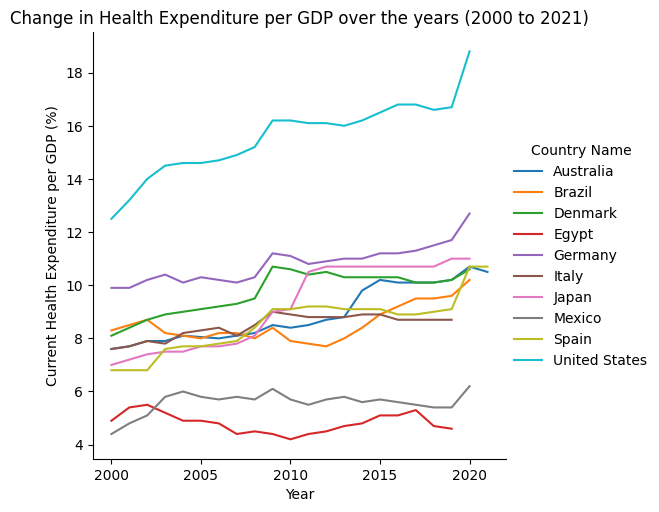

In [19]:
def health_expenditure_suicide_rates(WHO_suicide):
    """
    Takes in a merged dataset and returns a plot of change in health expenditure
    per GDP from 2000 to 2021. 
    """
    WHO_suicide_grouped = WHO_suicide.groupby(["Country Name", "Year"])["Death rate per 100 000 population"].sum().reset_index()
    WHO_suicide_merged = WHO_suicide_grouped.merge(WHO_data_filtered, left_on=["Country Name", "Year"], right_on=["country", "year"], how="left")

    che_data = WHO_suicide_merged[WHO_suicide_merged["che_gdp"].notna()]
    p = sns.relplot(data = che_data, x = "Year", y = "che_gdp", hue = "Country Name", kind = "line")
    plt.xlabel("Year")
    plt.ylabel("Current Health Expenditure per GDP (%)")
    plt.title(f"Change in Health Expenditure per GDP over the years ({che_data['Year'].min()} to {che_data['Year'].max()})")
    return p

ax = health_expenditure_suicide_rates(WHO_suicide).facet_axis(0,0)    
assert ax.get_title() == "Change in Health Expenditure per GDP over the years (2000 to 2021)"
assert ax.get_xlabel() == "Year", "Label does not match expected"
assert ax.get_ylabel() == "Current Health Expenditure per GDP (%)", "Label does not match expected"


assert sorted([tuple(xy) for xy in line.get_xydata()] for line in ax.get_lines())[10][:20] == [(2000.0, 4.4), (2001.0, 4.8), 
    (2002.0, 5.1), (2003.0, 5.8), (2004.0, 6.0), (2005.0, 5.8), (2006.0, 5.7), (2007.0, 5.8), (2008.0, 5.7), 
    (2009.0, 6.1), (2010.0, 5.7), (2011.0, 5.5), (2012.0, 5.7), (2013.0, 5.8), (2014.0, 5.6), (2015.0, 5.7), 
    (2016.0, 5.6), (2017.0, 5.5), (2018.0, 5.4), (2019.0, 5.4)], "data not matching"

    

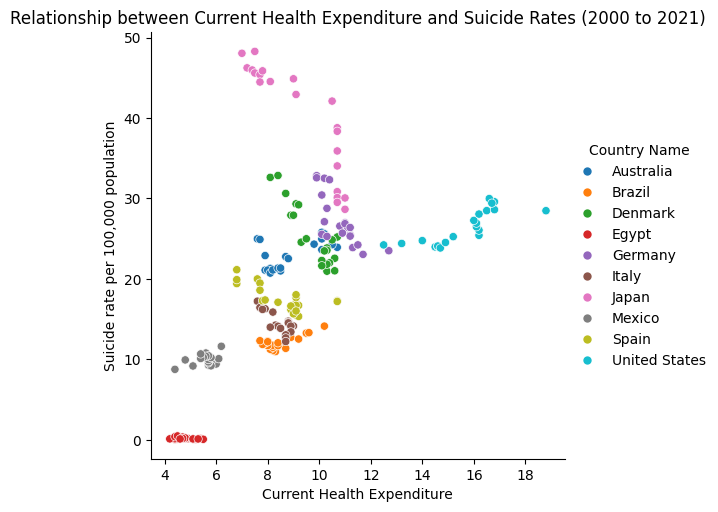

In [20]:
def health_suicide_relationship(WHO_suicide):
    """
    Takes in a merged dataset and returns a plot displaying the 
    relationship between current health expenditure and suicide rates. 
    """
    WHO_suicide_grouped = WHO_suicide.groupby(["Country Name", "Year"])["Death rate per 100 000 population"].sum().reset_index()
    WHO_suicide_merged = WHO_suicide_grouped.merge(WHO_data_filtered, left_on=["Country Name", "Year"], right_on=["country", "year"], how="left")

    che_data = WHO_suicide_merged[WHO_suicide_merged["che_gdp"].notna()]
    p = sns.relplot(data=che_data, x="che_gdp", y= "Death rate per 100 000 population", hue="Country Name")
    plt.xlabel("Current Health Expenditure")
    plt.ylabel("Suicide rate per 100,000 population")
    plt.title(f"Relationship between Current Health Expenditure and Suicide Rates ({che_data['Year'].min()} to {che_data['Year'].max()})")
    return p

ax = health_suicide_relationship(WHO_suicide).facet_axis(0,0)   

scatter_data = ax.collections[0].get_offsets()

sorted_data = sorted([tuple(point) for point in scatter_data])

assert sorted_data[:20] == [(4.2, 0.1200054763157894), (4.4, 0.06408833789473681), (4.4, 0.1382387915789473), 
    (4.4, 0.3910002931578947), (4.4, 8.76044903), (4.5, 0.113219167368421), (4.5, 0.4861151970588235), 
    (4.6, 0.11268584631578929), (4.7, 0.1758379636842105), (4.7, 0.34425874176470583), (4.8, 0.1692784894736841), 
    (4.8, 0.23399248947368412), (4.8, 9.932804764210527), (4.9, 0.1315764894736841), (4.9, 0.1558056131578947), 
    (4.9, 0.17333071947368411), (5.1, 0.0966269157894736), (5.1, 0.11485214473684201), (5.1, 9.180909923157895), 
    (5.2, 0.0736124752631578)]

assert ax.get_title() == "Relationship between Current Health Expenditure and Suicide Rates (2000 to 2021)"
assert ax.get_xlabel() == "Current Health Expenditure", "Label does not match expected"
assert ax.get_ylabel() == "Suicide rate per 100,000 population", "Label does not match expected"